# Homework 7 - Dave Coltri

This has multiple parts, so read carefully.

1. Log into canvas and watch the 2 short lectures on Naive Bayes and Spam Filters and Word clouds.  (You watched the first 10 seconds last week, so I know everyone can see it)

2. Refer back to the old slides on decision trees if you don't remember them

3. Either find a data set you like or use this one https://www.kaggle.com/c/titanic/data and build a decision tree based on the data.

4. You may use either R or Python.  If you want to get fancy, see http://blog.revolutionanalytics.com/2013/06/plotting-classification-and-regression-trees-with-plotrpart.html

5. Using the same data set from above do a Naive Bayes classification on the data like in the video lecture above.

6. Compare the results between your Decision Tree and the Naive Bayes algorithm. Which is more accurate?

7. Paste summary and plots into a Microsoft Word document or Excel or Jupyter notebook and create a pdf or html file so I don't have to compile your code to get an answer.

In [0]:
# Imports
import pandas as pd
pd.options.mode.chained_assignment = None
import re as re

from sklearn import metrics
from sklearn.model_selection import train_test_split

In [64]:
# Load Training Data
train = pd.read_csv("train.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Cleaning

After looking at the data, it's clear we need to clean it up before we can do anything with it.

The bulk of the data cleaning methodology was cribbed from https://www.kaggle.com/sinakhorami/titanic-best-working-classifier 



In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 'Family Size'

We can create a new field for family size using sibsp and parch

In [66]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


We'll do a similar thing for whether or not the person is alone

In [67]:
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


# Embarked

Embarked is missing values, so we'll guess and fill those in with the most occuring value, 'S'

In [68]:
train['Embarked'] = train['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


# Fare

Similarly, fare is missing some values. We'll replace the missing values with the median value of the fares, and then categorize it.


In [69]:
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


# Age

Age also has some missing values. We'll once again guess by generating random numbers between mean - standard deviation and mean + standard deviation and then categorize it

In [70]:
age_avg 	   = train['Age'].mean()
age_std 	   = train['Age'].std()
age_null_count = train['Age'].isnull().sum()

age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
train['Age'][np.isnan(train['Age'])] = age_null_random_list
train['Age'] = train['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.522523
1   (16.0, 32.0]  0.357303
2   (32.0, 48.0]  0.368627
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


# Name 

Name has a title associated with it, we can't use the full name, but we can probably use the title. 


In [71]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

train['Title'] = train['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [72]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# Final Classification

We have the data 'cleaned' up to the point where we can apply some classifications and then drop the unwanted columns from our dataframe

In [0]:
# Mapping Sex
train['Sex'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train['Title'] = train['Title'].map(title_mapping)
train['Title'] = train['Title'].fillna(0)

# Mapping Embarked
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Mapping Fare
train.loc[ train['Fare'] <= 7.91, 'Fare'] = 0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454), 'Fare'] = 1
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31), 'Fare']   = 2
train.loc[ train['Fare'] > 31, 'Fare'] = 3
train['Fare'] = train['Fare'].astype(int)

# Mapping Age
train.loc[ train['Age'] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age'] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age'] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), 'Age'] = 3
train.loc[ train['Age'] > 64, 'Age'] = 4

Feature Selection

In [74]:
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

print (train.head())

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1


In [0]:
# Split the training data into X_train, X_test, y_train, y_test
X = train.drop('Survived', 1)
y = train.Survived
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3,random_state=1)

# Decision Tree Classifier

Now we're ready to use the test/train data with a decision tree classifier


In [76]:
from sklearn.tree import DecisionTreeClassifier
# Train the decision tree classifier
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

# Model Accuracy & F1 Score - how often is the classifier correct?
print("Decision Tree Accuracy Score:",metrics.accuracy_score(y_test, y_pred))
print("Decision Tree F1 Score:",metrics.f1_score(y_test, y_pred))

Decision Tree Accuracy Score: 0.7574626865671642
Decision Tree F1 Score: 0.6700507614213198


# Printing our Decision Tree Classifier

Now that we have trained a model for our decision tree classifier we can print a visual representation of our decision tree

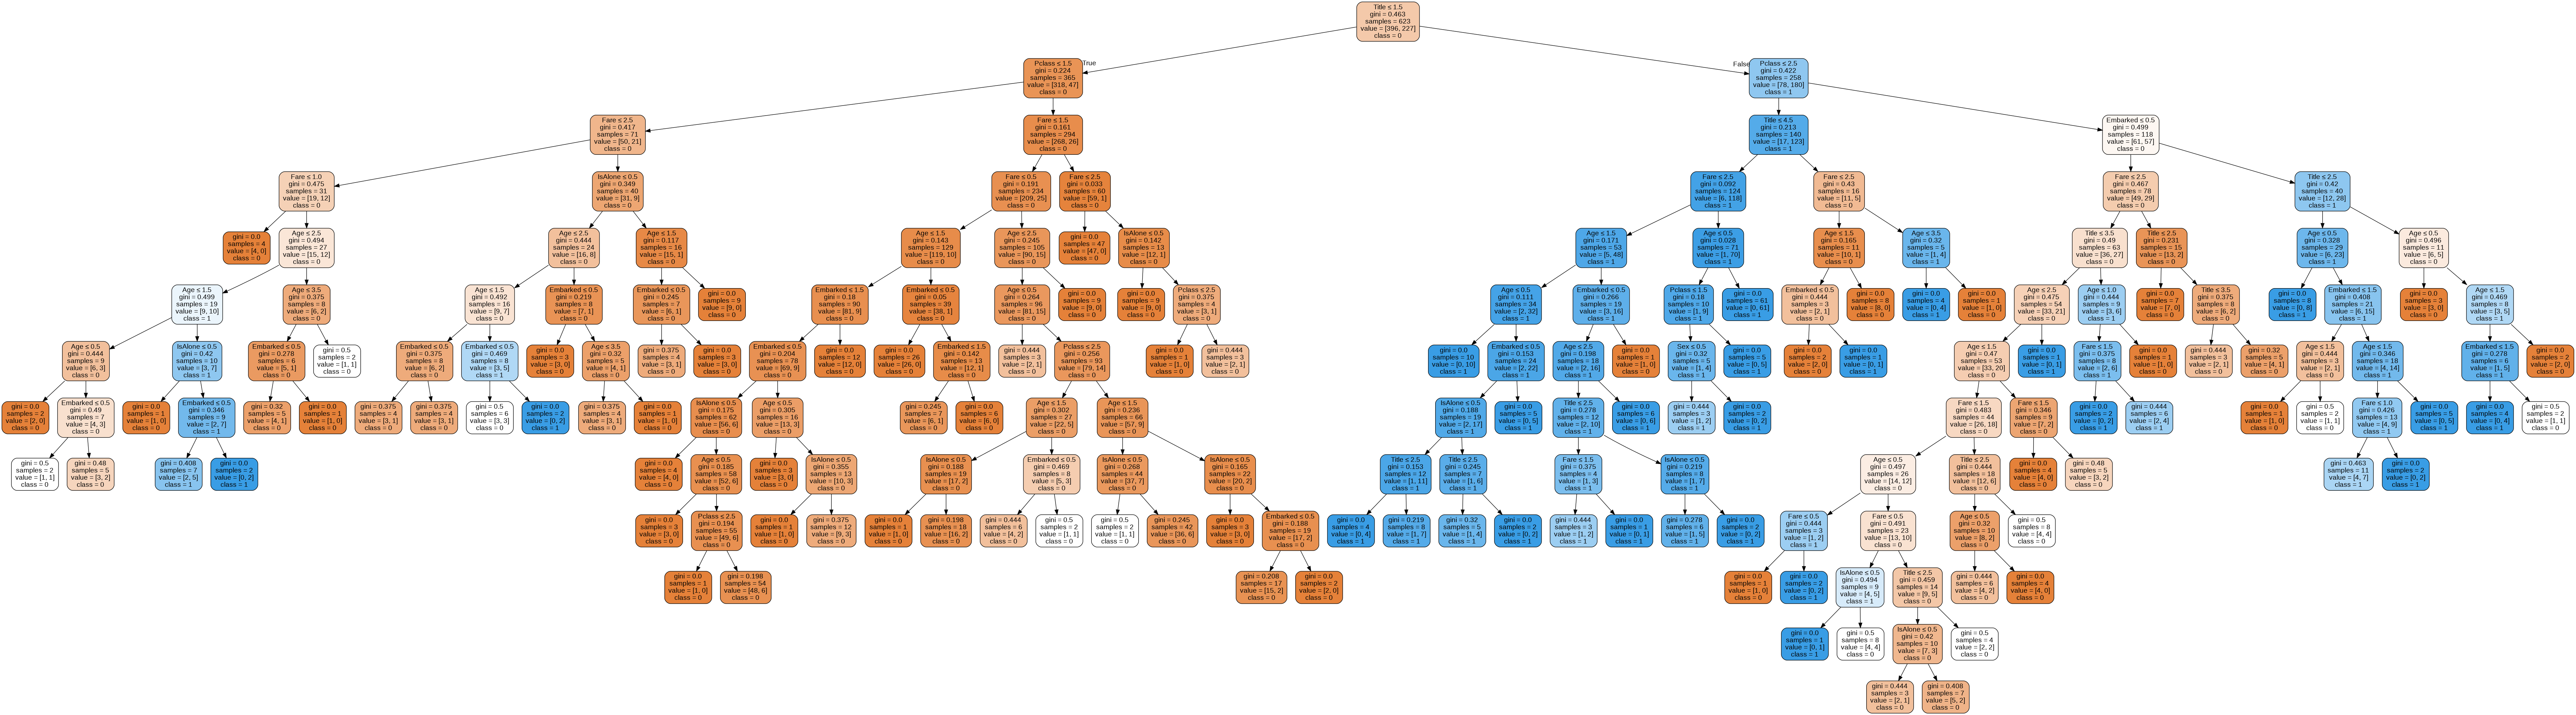

In [77]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

cols = ["Pclass", "Sex", "Age", "Fare", "Embarked", "IsAlone", "Title"]

dot_data = StringIO()
export_graphviz(dt_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = cols, class_names=['0', '1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 'Naive Bayes' or 'Idiot Bayes' because 'Idiot Bayes' is funny

Now we can also create a Naive Bayes classifier

In [78]:
from sklearn.naive_bayes import MultinomialNB
# Train the Multinomial naive bayes classifier
nb_clf = MultinomialNB()
nb_clf = nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

# Model Accuracy & F1 Score - how often is the classifier correct?
print("Multinomial NB Accuracy Score:",metrics.accuracy_score(y_test, y_pred))
print("Multinomial NB F1 Score:",metrics.f1_score(y_test, y_pred))

Multinomial NB Accuracy Score: 0.7089552238805971
Multinomial NB F1 Score: 0.6249999999999999


# Summary 

Decision Tree:
- Accuracy Score: 0.7686567164179104
- F1 Score: 0.693069306930693

Multinomial Naive Bayes:
- Accuracy Score: 0.7089552238805971
- F1 Score: 0.6249999999999999

So it looks like across the board the decision tree is more successfully classifying this data than Multinomial Naive Bayes is. 

# Extra Question

There's multiple implementations of Naive Bayes in Scikit Learn. What if Multinomial Naive Bayes isn't the best? Let's take a look.


In [79]:
from sklearn.naive_bayes import GaussianNB
# Train the GaussianNB naive bayes classifier
g_clf = GaussianNB()
g_clf = g_clf.fit(X_train, y_train)

y_pred = g_clf.predict(X_test)

# Model Accuracy & F1 Score - how often is the classifier correct?
print("Gaussian NB Accuracy Score:",metrics.accuracy_score(y_test, y_pred))
print("Gaussian NB F1 Score:",metrics.f1_score(y_test, y_pred))

Gaussian NB Accuracy Score: 0.7313432835820896
Gaussian NB F1 Score: 0.6974789915966387


In [80]:
from sklearn.naive_bayes import BernoulliNB
# Train the BernoulliNB naive bayes classifier
b_clf = BernoulliNB()
b_clf = b_clf.fit(X_train, y_train)

y_pred = b_clf.predict(X_test)

# Model Accuracy & F1 Score - how often is the classifier correct?
print("Bernoulli NB Accuracy Score:",metrics.accuracy_score(y_test, y_pred))
print("Bernoulli NB F1 Score:",metrics.f1_score(y_test, y_pred))

Bernoulli NB Accuracy Score: 0.75
Bernoulli NB F1 Score: 0.6854460093896714


In [81]:
from sklearn.naive_bayes import CategoricalNB
# Train the CategoricalNB naive bayes classifier
c_clf = CategoricalNB()
c_clf = c_clf.fit(X_train, y_train)

y_pred = c_clf.predict(X_test)

# Model Accuracy & F1 Score - how often is the classifier correct?
print("Categorical NB Accuracy Score:",metrics.accuracy_score(y_test, y_pred))
print("Categorical NB F1 Score:",metrics.f1_score(y_test, y_pred))

Categorical NB Accuracy Score: 0.75
Categorical NB F1 Score: 0.7074235807860262


In [82]:
from sklearn.naive_bayes import ComplementNB
# Train the ComplementNB naive bayes classifier
comp_clf = ComplementNB()
comp_clf = comp_clf.fit(X_train, y_train)

y_pred = comp_clf.predict(X_test)

# Model Accuracy & F1 Score - how often is the classifier correct?
print("Complement NB Accuracy Score:",metrics.accuracy_score(y_test, y_pred))
print("Complement NB F1 Score:",metrics.f1_score(y_test, y_pred))

Complement NB Accuracy Score: 0.7276119402985075
Complement NB F1 Score: 0.6995884773662551


# Extra Question - Conclusion

It looks like for our data set, the Categorical NB classifier worked the best! Close to, if not better than the decision tree!